In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)

from polimi.utils._catboost import (
    _preprocessing_history_trendiness_scores, 
    add_history_trendiness_scores_feature, 
    _preprocessing_mean_delay_features, 
    add_mean_delays_features, 
    _preprocessing_window_features, 
    add_window_features, 
    add_trendiness_feature_categories, 
    _preprocessing_article_endorsement_feature, 
    get_unique_categories,
    add_trendiness_feature
)

from ebrec.evaluation.metrics_protocols import *

from catboost import CatBoostClassifier

2024-05-12 14:21:18.203390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 14:21:19.999369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Memory Utils

In [2]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.9


In [3]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [4]:
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.212


# Articles Preprocessing

In [5]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')),
    pl.col('topics').list.len().alias('num_topics'),
    (pl.col('total_pageviews') / pl.col('total_inviews')).alias('total_pageviews/inviews')
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 58.23 MB
Memory usage after optimization is: 58.00 MB
Decreased by 0.4%

RAM memory GB usage = 1.222


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null


In [6]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['LOC', 'ORG', 'EVENT', 'PER', 'PROD', 'MISC']

In [7]:
# in case of two category_str for the same category, one of the two is picked
unique_categories_df = articles.select(['category', 'category_str']).unique('category').drop_nulls('category')
unique_categories = {
    row['category']: row['category_str'] for row in unique_categories_df.iter_rows(named=True)
}
unique_categories

{539: 'ferie',
 2504: 'bibliotek',
 414: 'underholdning',
 140: 'krimi',
 572: 'side9',
 2975: 'penge',
 498: 'musik',
 2731: 'dagsorden',
 2737: 'podcast',
 2341: 'plus',
 2889: 'auto',
 561: 'haandvaerkeren',
 22: 'horoskoper',
 1505: 'vin',
 457: 'forbrug',
 731: 'services',
 2077: 'opinionen',
 2: 'incoming',
 529: 'biler',
 118: 'nyheder',
 806: 'om_ekstra_bladet',
 142: 'sport',
 565: 'sex_og_samliv',
 68: 'video',
 512: 'nationen'}

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [8]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 1.237


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32]
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]"


In [10]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [11]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [12]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75,
    learning_method='online'
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 29.5 s, sys: 32.6 ms, total: 29.5 s
Wall time: 29.9 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]","[0.143672, 0.288237, … 0.143774]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]","[0.309316, 0.112325, … 0.159053]"


In [13]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]",0.143672,0.288237,0.143677,0.280641,0.143774
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]",0.309316,0.112325,0.301761,0.117545,0.159053


# History preprocessing

In [14]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [15]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:15,  1.06it/s]                        



RAM memory GB usage = 1.41
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 16.9 s, sys: 2.1 s, total: 19 s
Wall time: 15.8 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,LOCPct,ORGPct,EVENTPct,PERPct,PRODPct,MISCPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,1,16,"[0.016041, 0.062928, … 0.178427]",0.804196,0.888112,0.202797,0.874126,0.237762,0.223776
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.776515,0.852273,0.087121,0.787879,0.318182,0.117424


In [16]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [17]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [18]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [19]:
from RecSys_Course_AT_PoliMi.Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from RecSys_Course_AT_PoliMi.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from RecSys_Course_AT_PoliMi.Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from RecSys_Course_AT_PoliMi.Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Similarity column 43774 (100.0%), 333.78 column/sec. Elapsed time 2.19 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 40.91 sec. Users per second: 369


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214435,0.214678,0.469908,0.319615,0.054883,0.766609,0.953165,...,0.997953,0.76504,0.997953,0.002087,5.362685,0.952585,0.016849,0.419602,3.357939,0.009295


In [20]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 7.17 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 24.03 sec. Users per second: 629


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342635,0.345148,0.048664,0.261759,0.263204,0.670412,0.39226,0.085224,0.858722,1.275575,...,0.997953,0.856964,0.997953,0.001871,5.929547,0.95823,0.015104,0.463956,3.324192,0.009294


In [21]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 8min 17s, sys: 10min 28s, total: 18min 45s
Wall time: 1min 48s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
201766794,9769622,1.0,1.0,0.567422,0.712161,1.0,0.700518
198662096,9773282,0.206444,0.412888,0.297323,0.173898,0.347796,0.342574
563933707,9772366,0.0,0.0,0.0,0.0,0.0,0.0
3155674,9756785,0.052014,0.135236,0.322587,0.076138,0.197959,0.514661
171198848,8560195,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
del URM_ner
del URM_ner_test
del ner_inview_scores
del ner_interactions
del ner_interactions_test
gc.collect()

0

# Creating Training Dataframe

In [23]:
def normalize_endorsement(articles_endorsement_raw):
    return articles_endorsement.sort(by='impression_time').with_columns(
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').sum().over('impression_time')
        ).alias('normalized_endorsement_10h'),
        (
            pl.col('endorsement_10h') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_10h_diff_rolling'),
        (
            pl.col('endorsement_10h').rolling_mean(5, min_periods=1).over('article') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_macd'),
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').quantile(0.8).over('impression_time')
        ).alias('endorsement_quantile_norm_10h')
    ).with_columns(
        (
            pl.col('normalized_endorsement_10h') / 
            pl.col('normalized_endorsement_10h').rolling_max(10, min_periods=1).over('impression_time')
        ).alias('normalized_endorsement_10h_rolling_max_ratio'),
    )
    

def add_article_endorsement_feature(df_features, normalized_endorsement):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32))
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                         .join(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}), on=['article','rounded_impression_time'], how='left')\
                         .drop('rounded_impression_time')

In [24]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_train, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_train)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_train, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_train, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

topics = articles.select("topics").explode("topics").unique()
topics = [topic for topic in topics["topics"] if topic is not None]

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 'total_pageviews/inviews']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours'),
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()

16it [00:24,  1.55s/it]                        
2427it [00:05, 429.23it/s]                          
16it [00:02,  7.39it/s]                        
16it [00:02,  6.59it/s]                        
100%|██████████| 506/506 [00:03<00:00, 163.51it/s]



RAM memory GB usage = 2.986
Memory usage of dataframe is 816.08 MB
Memory usage after optimization is: 497.97 MB
Decreased by 39.0%

RAM memory GB usage = 2.668
CPU times: user 23min 12s, sys: 47.6 s, total: 23min 59s
Wall time: 2min 49s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32
280241665,9767483,102231,2023-05-18 08:54:26,0,1,8.0,null,false,2,null,false,641624,null,8,32,40,4,8,0.25,0.2,0.062136,false,2023-05-16 08:03:02,512,0.9323,"""Negative""",3,4,22,266,3,130292,548808,1.0499341e7,0.237409,2,48,true,true,false,true,false,false,0.371546,0.44226,0.208941,0.279484,0.326529,0.181707,251.134567,117.441025,8.088359,196.529663,2.395778,64.390503,349,53,0,4,1,0,0,0,5,26,12,24,0.000746,8.9,4.9,0.033103,0.018433
166401825,9778661,451220,2023-05-24 08:12:40,0,1,81.0,null,false,2,null,false,600262,null,85,332,536,3,8,0.256024,0.158582,0.560811,false,2023-05-24 06:47:59,142,0.8044,"""Positive""",1,10,18,246,4,22483,174821,1.102027e6,0.128606,0,1,true,true,true,true,true,false,0.327961,0.232559,0.85692,0.28288,0.147596,0.668442,189.766663,401.018463,1.83221,46.379601,1.916667,47.540001,130,126,69,28,1,0,0,0,17,24,118,767,0.00913,16.0,10.6,0.432113,0.327358
299916852,9769622,2471976,2023-05-19 06:23:40,0,1,21.0,null,false,2,null,false,1185915,null,25,112,155,5,6,0.223214,0.16129,0.182114,false,2023-05-17 16:09:59,140,0.9956,"""Negative""",0,7,20,125,2,211545,941084,1.2275968e7,0.224789,1,38,true,true,false,false,false,false,0.213765,0.971155,0.6612,0.299445,0.982678,0.866554,243.220978,176.763824,9.866658,239.443207,2.288389,58.951309,178,87,2,143,1,0,0,0,31,72,62,591,0.005977,8.7,4.1,0.31689,0.337714
170961438,9779777,1135986,2023-05-25 05:17:41,0,2,69.0,null,false,2,null,false,1082243,null,90,276,430,4,5,0.326087,0.209302,0.50365,false,2023-05-24 20:48:35,414,0.5267,"""Positive""",2,10,24,259,4,169396,751298,1.0188939e7,0.225471,0,8,false,true,false,true,true,false,0.049662,0.122791,0.256825,0.050141,0.110946,0.24338,239.789352,276.091125,21.730909,524.674072,1.043584,28.515739,160,96,36,222,1,0,0,1,36,149,58,2801,0.030662,57.400002,30.4,1.691425,1.0
228136469,9778326,2112652,2023-05-24 06:36:54,0,1,101.0,null,false,2,null,false,1383101,null,80,265,427,3,6,0.301887,0.187354,0.447635,false,2023-05-23 20:22:31,142,0.6526,"""Negative""",1,7,14,176,2,77780,433396,2.118912e6,0.179466,0,10,true,true,true,true,false,true,0.530811,0.405914,0.834093,0.538734,0.425522,0.892414,245.881409,375.078339,6.49905,158.554962,10.237197,252.218323,310,61,0,84,1,0,0,0,59,163,118,2781,0.035894,-35.200001,-21.0,2.366808,1.0


In [25]:
train_ds.shape

(2585747, 73)

## Session Features

In [26]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [27]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 2.518
CPU times: user 1.97 s, sys: 231 ms, total: 2.2 s
Wall time: 1.69 s


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
649781,2023-05-18 04:21:27,0,[8422665],6.0
426815,2023-05-17 11:22:29,0,[9769380],3.0


In [28]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 2.88


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,…,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,…,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i64,f64,i64,bool,bool
280241665,9767483,102231,2023-05-18 08:54:26,0,1,8.0,null,false,2,null,false,null,8,32,40,4,8,0.25,0.2,0.062136,false,512,0.9323,"""Negative""",3,4,22,266,3,130292,548808,1.0499341e7,0.237409,2,48,true,…,true,false,false,0.371546,0.44226,0.208941,0.279484,0.326529,0.181707,251.134567,117.441025,8.088359,196.529663,2.395778,64.390503,349,53,0,4,1,0,0,0,5,26,12,24,0.000746,8.9,4.9,0.033103,0.018433,8,8.5,-162,true,false
166401825,9778661,451220,2023-05-24 08:12:40,0,1,81.0,null,false,2,null,false,null,85,332,536,3,8,0.256024,0.158582,0.560811,false,142,0.8044,"""Positive""",1,10,18,246,4,22483,174821,1.102027e6,0.128606,0,1,true,…,true,true,false,0.327961,0.232559,0.85692,0.28288,0.147596,0.668442,189.766663,401.018463,1.83221,46.379601,1.916667,47.540001,130,126,69,28,1,0,0,0,17,24,118,767,0.00913,16.0,10.6,0.432113,0.327358,0,0.214286,21,false,false


In [29]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.538783,0.0254


In [30]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [31]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 538.35 MB
Memory usage after optimization is: 486.25 MB
Decreased by 9.7%

RAM memory GB usage = 2.907
CPU times: user 926 ms, sys: 224 ms, total: 1.15 s
Wall time: 899 ms


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,…,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
280241665,9767483,102231,2023-05-17,0,1,8.0,null,false,2,null,false,null,8,32,40,4,8,0.25,0.2,0.062136,false,512,0.9323,"""Negative""",3,4,22,266,3,130292,548808,1.0499341e7,0.237409,2,48,true,…,false,false,0.371546,0.44226,0.208941,0.279484,0.326529,0.181707,251.134567,117.441025,8.088359,196.529663,2.395778,64.390503,349,53,0,4,1,0,0,0,5,26,12,24,0.000746,8.9,4.9,0.033103,0.018433,8,8.5,-162,true,false,0.015873
166401825,9778661,451220,2023-05-23,0,1,81.0,null,false,2,null,false,null,85,332,536,3,8,0.256024,0.158582,0.560811,false,142,0.8044,"""Positive""",1,10,18,246,4,22483,174821,1.102027e6,0.128606,0,1,true,…,true,false,0.327961,0.232559,0.85692,0.28288,0.147596,0.668442,189.766663,401.018463,1.83221,46.379601,1.916667,47.540001,130,126,69,28,1,0,0,0,17,24,118,767,0.00913,16.0,10.6,0.432113,0.327358,0,0.214286,21,false,false,0.246377


# Adding history features

In [32]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def list_pct_matches_with_constant(a, value) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with a constant value.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise(pl.col(a).list.count_matches(value) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
#         ).sort(by='impression_time_fixed').group_by(['impression_id', 'article']).agg(
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
#             pl.col("JS").tail(5).mean().alias("mean_JS_tail_5"),
#             pl.col("JS").tail(10).mean().alias("mean_JS_tail_10"),
#             pl.col("JS").tail(25).mean().alias("mean_JS_tail_25"),
#             pl.col("JS").quantile(0.3).alias("quantile_JS_0.3"),
#             pl.col("JS").quantile(0.7).alias("quantile_JS_0.7"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
#             pl.col("topic_model_cosine").tail(5).mean().alias("mean_topic_model_cosine_tail_5"),
#             pl.col("topic_model_cosine").tail(10).mean().alias("mean_topic_model_cosine_tail_10"),
#             pl.col("topic_model_cosine").tail(25).mean().alias("mean_topic_model_cosine_tail_25"),
#             pl.col("topic_model_cosine").quantile(0.3).alias("quantile_topic_model_cosine_0.3"),
#             pl.col("topic_model_cosine").quantile(0.7).alias("quantile_topic_model_cosine_0.7"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)
train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

259it [32:19,  7.49s/it]                         


Memory usage of dataframe is 1537.68 MB
Memory usage after optimization is: 1155.45 MB
Decreased by 24.9%

RAM memory GB usage = 5.571


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,Entity_ORG_Present,…,MostFrequentWeekday,MostFrequentHour,LOCPct,ORGPct,EVENTPct,PERPct,PRODPct,MISCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_ferie_Pct,Category_bibliotek_Pct,Category_underholdning_Pct,Category_krimi_Pct,Category_side9_Pct,Category_penge_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_podcast_Pct,Category_plus_Pct,Category_auto_Pct,Category_haandvaerkeren_Pct,Category_horoskoper_Pct,Category_vin_Pct,Category_forbrug_Pct,Category_services_Pct,Category_opinionen_Pct,Category_incoming_Pct,Category_biler_Pct,Category_nyheder_Pct,Category_om_ekstra_bladet_Pct,Category_sport_Pct,Category_sex_og_samliv_Pct,Category_video_Pct,Category_nationen_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
411254250,9770102,2240301,0,2,22.0,null,false,2,null,false,null,74,199,392,6,4,0.371859,0.188776,0.394059,false,118,0.7452,"""Negative""",2,5,18,666,5,119621,564474,8.289813e6,0.211916,0,8,false,true,…,5,4,0.849057,0.886792,0.075472,0.830189,0.301887,0.113208,0.247172,true,6,0.90566,0.0,0.0,0.113208,0.264151,0.0,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113208,0.0,0.0,0.0,0.0,0.415094,0.0,0.075472,0.0,0.0,0.0
261409044,9776862,2314467,0,1,49.0,100.0,false,2,null,false,null,47,106,185,2,6,0.443396,0.254054,0.179661,false,118,0.5975,"""Neutral""",1,6,15,243,4,101093,339333,3.74651e6,0.297917,0,1,false,true,…,1,7,0.764286,0.914286,0.152381,0.82619,0.235714,0.157143,0.358123,true,10,0.978571,0.0,0.0,0.192857,0.228571,0.0,0.014286,0.007143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011905,0.0,0.0,0.0,0.0,0.404762,0.0,0.107143,0.002381,0.004762,0.02619


In [33]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]

train_ds = train_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).rank(method='min').over(pl.col('impression_id'))).alias(f'{c}_rank_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
)

In [34]:
normalize_columns = ['total_pageviews', 'total_inviews', 'total_read_time','click_ratio']
train_ds = train_ds.join(articles.select(['article_id','total_pageviews','total_inviews', 'total_read_time']).fill_null(0), left_on = 'article', right_on = 'article_id')\
    .with_columns(
        (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
    )\
    .with_columns(
        *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in normalize_columns],
    ).drop(['click_ratio', 'total_pageviews', 'total_inviews', 'total_read_time','click_ratio'])
    
emb = pl.read_parquet("/home/ubuntu/dataset/emotions_embedding.parquet").with_columns(pl.col("emotion_scores").list.to_struct()).unnest("emotion_scores")

train_ds = train_ds.join(emb, left_on = 'article', right_on='article_id', how='left').rename({'field_0': 'emotion_0', 'field_1': 'emotion_1', 'field_2' : 'emotion_2', 'field_3': 'emotion_3',
             'field_4': 'emotion_4', 'field_5':'emotion_5'})
embedding_len = 6
train_ds = train_ds.join(history_train.select(['user_id','article_id_fixed']).explode('article_id_fixed').join(emb, left_on = 'article_id_fixed', right_on='article_id', how='left')\
.group_by('user_id').agg(
            [pl.col(f'field_{i}').mean().cast(pl.Float32).alias(f'user_emotion{i}') for i in range(embedding_len)]), on='user_id')


emb = pl.read_parquet('/mnt/ebs_volume_2/click_predictors/train_click_predictor.parquet')
emb_col = emb.drop(['user_id','article']).columns

emb = train_ds.select(['user_id','article','impression_id']).join(emb, on=['user_id','article'], how='left').with_columns(
    *[(pl.col(col) / pl.col(col).max().over('user_id')) for col in emb_col],
    *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in emb_col],
)

train_ds = train_ds.join(emb, on=['user_id','article'], how='left')

# train_ds = train_ds.with_columns(
#     *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in emb_col],
# )
del emb
train_ds = reduce_polars_df_memory_size(train_ds)
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Memory usage of dataframe is 6844.06 MB
Memory usage after optimization is: 5559.30 MB
Decreased by 18.8%

RAM memory GB usage = 9.675


In [35]:
train_ds.head()

impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,Entity_PROD_Present,…,TW_click_predictor_kenneth,SP%W_click_predictor_kenneth,readtime_click_predictor_kenneth,TW_click_predictor_w2v,SP%W_click_predictor_w2v,readtime_click_predictor_w2v,TW_click_predictor_emotion,SP%W_click_predictor_emotion,readtime_click_predictor_emotion,imp_norm_emotions_user_item_distance,imp_norm_word2vec_user_item_distance,imp_norm_contrastive_user_item_distance,imp_norm_roberta_user_item_distance,imp_norm_distil_user_item_distance,imp_norm_bert_user_item_distance,imp_norm_kenneth_user_item_distance,imp_norm_TW_click_predictor_distilbert,imp_norm_SP%W_click_predictor_distilbert,imp_norm_readtime_click_predictor_distilbert,imp_norm_TW_click_predictor_bert,imp_norm_SP%W_click_predictor_bert,imp_norm_readtime_click_predictor_bert,imp_norm_TW_click_predictor_roberta,imp_norm_SP%W_click_predictor_roberta,imp_norm_readtime_click_predictor_roberta,imp_norm_TW_click_predictor_contrastive,imp_norm_SP%W_click_predictor_contrastive,imp_norm_readtime_click_predictor_contrastive,imp_norm_TW_click_predictor_kenneth,imp_norm_SP%W_click_predictor_kenneth,imp_norm_readtime_click_predictor_kenneth,imp_norm_TW_click_predictor_w2v,imp_norm_SP%W_click_predictor_w2v,imp_norm_readtime_click_predictor_w2v,imp_norm_TW_click_predictor_emotion,imp_norm_SP%W_click_predictor_emotion,imp_norm_readtime_click_predictor_emotion
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,f32,i16,i32,bool,bool,bool,bool,bool,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
411254250,9770102,2240301,0,2,22.0,null,false,2,null,false,null,74,199,392,6,4,0.371859,0.188776,0.394059,false,118,0.7452,"""Negative""",2,5,18,666,5,0.211916,0,8,false,true,false,true,false,…,0.978757,0.869061,0.859276,0.68578,0.534368,0.543533,0.302893,0.168391,0.164455,0.16957,0.811307,1.0,0.232934,1.0,0.303825,1.0,0.75791,1.0,1.0,0.466247,0.315864,0.30567,0.278948,0.250604,0.244758,1.0,1.0,1.0,1.0,1.0,1.0,0.801768,0.855796,0.835805,0.302893,0.168391,0.164455
261409044,9776862,2314467,0,1,49.0,100.0,false,2,null,false,null,47,106,185,2,6,0.443396,0.254054,0.179661,false,118,0.5975,"""Neutral""",1,6,15,243,4,0.297917,0,1,false,true,false,true,false,…,0.677238,0.522545,0.517152,0.345819,0.272978,0.275632,0.17619,0.168865,0.173831,0.371979,0.390595,0.878025,0.394618,0.237203,0.392015,0.738478,0.219601,0.250549,0.252461,0.447604,0.384003,0.392062,0.497058,0.412706,0.415428,1.0,0.884979,0.878691,0.806019,0.754234,0.738738,0.510423,0.403915,0.405427,0.319301,0.345631,0.368426
261409044,9776862,2314467,0,1,49.0,100.0,false,2,null,false,null,47,106,185,2,6,0.443396,0.254054,0.179661,false,118,0.5975,"""Neutral""",1,6,15,243,4,0.297917,0,1,false,true,false,true,false,…,0.677238,0.522545,0.517152,0.345819,0.272978,0.275632,0.17619,0.168865,0.173831,0.330435,0.523305,0.985796,0.484629,0.134941,0.240701,0.705207,0.132855,0.144294,0.145021,0.28028,0.236015,0.240721,0.576957,0.505559,0.505882,1.0,0.961765,0.985753,0.811455,0.714549,0.705021,0.690605,0.538976,0.538978,0.288143,0.30797,0.327301
261409044,9776862,2314467,0,1,49.0,100.0,false,2,null,false,null,47,106,185,2,6,0.443396,0.254054,0.179661,false,118,0.5975,"""Neutral""",1,6,15,243,4,0.297917,0,1,false,true,false,true,false,…,0.677238,0.522545,0.517152,0.345819,0.272978,0.275632,0.17619,0.168865,0.173831,0.218252,0.390595,0.854555,0.394618,0.237203,0.392015,0.

# Training

In [36]:
# subsample dataset

behaviors_subsample = behaviors_train.select(['impression_id','user_id','article_ids_inview','article_ids_clicked']) \
    .pipe(
        sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
    ).explode('article_ids_inview').drop('article_ids_clicked').rename({'article_ids_inview' : 'article'}) \
    .with_columns(pl.col('user_id').cast(pl.UInt32), pl.col('article').cast(pl.Int32)) \
    .select(['impression_id', 'user_id', 'article'])

train_ds = behaviors_subsample.join(train_ds, on=['impression_id','user_id','article'], how='left')
train_ds.head()

impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,Entity_PROD_Present,…,TW_click_predictor_kenneth,SP%W_click_predictor_kenneth,readtime_click_predictor_kenneth,TW_click_predictor_w2v,SP%W_click_predictor_w2v,readtime_click_predictor_w2v,TW_click_predictor_emotion,SP%W_click_predictor_emotion,readtime_click_predictor_emotion,imp_norm_emotions_user_item_distance,imp_norm_word2vec_user_item_distance,imp_norm_contrastive_user_item_distance,imp_norm_roberta_user_item_distance,imp_norm_distil_user_item_distance,imp_norm_bert_user_item_distance,imp_norm_kenneth_user_item_distance,imp_norm_TW_click_predictor_distilbert,imp_norm_SP%W_click_predictor_distilbert,imp_norm_readtime_click_predictor_distilbert,imp_norm_TW_click_predictor_bert,imp_norm_SP%W_click_predictor_bert,imp_norm_readtime_click_predictor_bert,imp_norm_TW_click_predictor_roberta,imp_norm_SP%W_click_predictor_roberta,imp_norm_readtime_click_predictor_roberta,imp_norm_TW_click_predictor_contrastive,imp_norm_SP%W_click_predictor_contrastive,imp_norm_readtime_click_predictor_contrastive,imp_norm_TW_click_predictor_kenneth,imp_norm_SP%W_click_predictor_kenneth,imp_norm_readtime_click_predictor_kenneth,imp_norm_TW_click_predictor_w2v,imp_norm_SP%W_click_predictor_w2v,imp_norm_readtime_click_predictor_w2v,imp_norm_TW_click_predictor_emotion,imp_norm_SP%W_click_predictor_emotion,imp_norm_readtime_click_predictor_emotion
u32,u32,i32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,f32,i16,i32,bool,bool,bool,bool,bool,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
149474,139836,9778728,0,2,13.0,null,false,2,null,false,null,150,521,836,3,7,0.287908,0.179426,0.880068,false,142,0.9654,"""Negative""",1,5,18,251,7,0.101772,0,0,false,true,true,true,true,…,0.667411,0.622013,0.608949,0.555292,0.550847,0.55908,0.268252,0.70398,0.742744,1.0,0.763286,0.985143,0.483018,0.25394,0.377859,0.844047,0.328909,0.254171,0.275561,0.520141,0.369664,0.369893,0.638431,0.509399,0.543359,0.931908,0.97453,0.976117,0.885542,0.820297,0.833935,0.555292,0.796077,0.798141,0.460265,1.0,1.0
149474,139836,9778669,0,2,13.0,null,false,2,null,false,null,85,199,313,3,7,0.427136,0.271565,0.336149,false,118,0.9481,"""Negative""",1,5,11,150,4,0.199447,0,1,false,true,false,true,true,…,0.753676,0.59187,0.593144,1.0,0.691951,0.700478,0.044277,0.27283,0.298851,0.384545,1.0,0.831456,0.703436,1.0,1.0,0.802027,1.0,1.0,1.0,1.0,1.0,1.0,0.901063,0.674577,0.74001,1.0,0.800638,0.804553,1.0,0.780545,0.81229,1.0,1.0,1.0,0.075971,0.387553,0.402361
149474,139836,9778657,1,2,13.0,null,false,2,null,false,null,45,117,183,3,7,0.384615,0.245902,0.197635,false,118,0.8347,"""Neutral""",2,6,31,336,3,0.226709,0,1,true,true,false,true,false,…,0.674043,0.520878,0.520099,0.543819,0.199499,0.196432,0.168207,0.108821,0.10582,0.17053,0.278453,0.422026,0.286743,0.503704,0.170233,0.715042,0.509061,0.517204,0.505264,0.308732,0.166852,0.164012,0.576311,0.286576,0.307743,0.950963,0.399418,0.407983,0.894341,0.686923,0.712258,0.543819,0.288313,0.280425,0.288608,0.154579,0.142471
150528,143471,9778682,0,2,25.0,null,false,2,null,false,null,69,206,334,3,7,0.334951,0.206587,0.347973,false,498,0.9546,"""Negative""",1,5,20,267,3,0.314928,0,1,false,true,true,true,true,…,0.527908,0.459147,0.45827,0.306806,0.268388,0.268777,0.10411,0.007399,0.007142,0.013769,0.370855,0.584776,0.368401,0.189347,0.201733,0.571196,0.196177,0.210069,0.208523,0.389999,0.20557

In [37]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [38]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 13.89


In [39]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=1000, rsm=0.7, subsample=0.5)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.229044


0:	learn: 0.5956357	total: 781ms	remaining: 13m
25:	learn: 0.4463582	total: 15.3s	remaining: 9m 34s
50:	learn: 0.4307523	total: 30.3s	remaining: 9m 24s
75:	learn: 0.4214397	total: 45.6s	remaining: 9m 14s
100:	learn: 0.4131592	total: 1m	remaining: 8m 55s
125:	learn: 0.4075735	total: 1m 14s	remaining: 8m 37s
150:	learn: 0.4026411	total: 1m 28s	remaining: 8m 19s
175:	learn: 0.3986123	total: 1m 42s	remaining: 8m
200:	learn: 0.3948412	total: 1m 57s	remaining: 7m 45s
225:	learn: 0.3915961	total: 2m 12s	remaining: 7m 32s
250:	learn: 0.3885645	total: 2m 26s	remaining: 7m 16s
275:	learn: 0.3857433	total: 2m 40s	remaining: 7m 2s
300:	learn: 0.3831251	total: 2m 55s	remaining: 6m 47s
325:	learn: 0.3805700	total: 3m 9s	remaining: 6m 32s
350:	learn: 0.3780773	total: 3m 24s	remaining: 6m 18s
375:	learn: 0.3758582	total: 3m 38s	remaining: 6m 2s
400:	learn: 0.3738015	total: 3m 52s	remaining: 5m 47s
425:	learn: 0.3718770	total: 4m 7s	remaining: 5m 32s
450:	learn: 0.3698641	total: 4m 22s	remaining: 5m 18

In [40]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 22.9 s, sys: 463 ms, total: 23.4 s
Wall time: 23.4 s


Text(0.5, 1.0, 'Catboost Feature Importances')

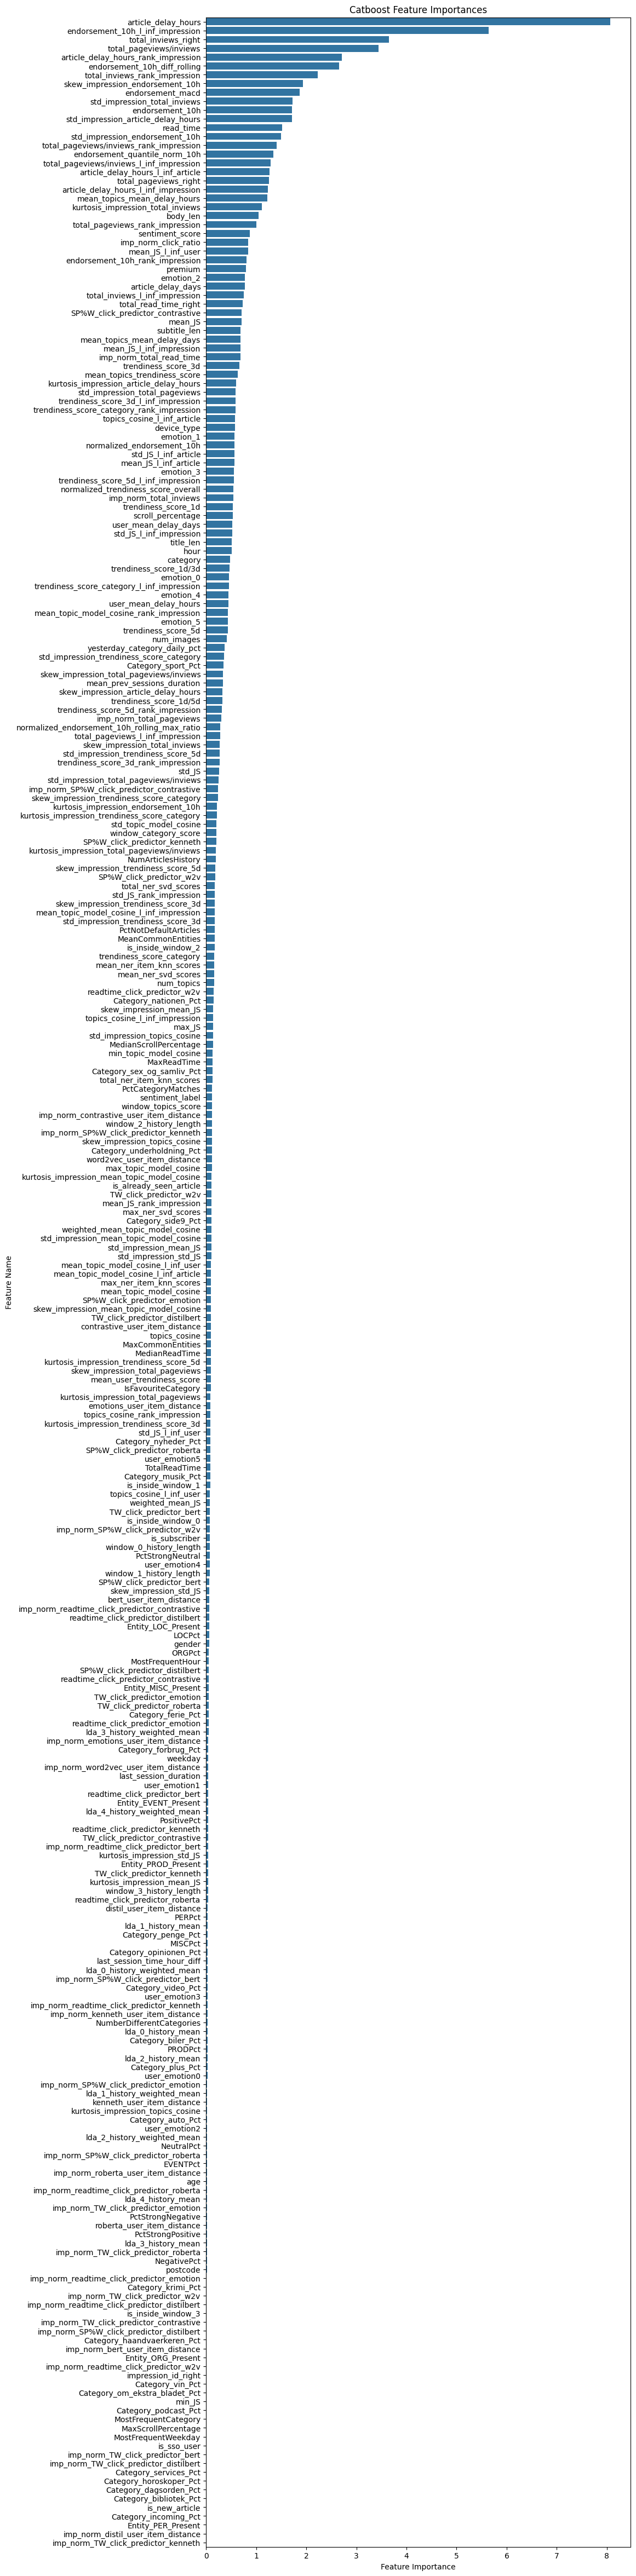

In [41]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 60))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [42]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 16.64


# Model Evaluation

In [43]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [44]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Similarity column 43774 (100.0%), 353.94 column/sec. Elapsed time 2.06 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 41.66 sec. Users per second: 368


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033198,0.241641,0.241975,0.493897,0.346765,0.060464,0.784651,1.033188,...,0.997914,0.783014,0.997914,0.002566,5.472959,0.953841,0.020604,0.428206,3.43338,0.010093


In [45]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 5.80 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 24.22 sec. Users per second: 632


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365382,0.368539,0.050795,0.283614,0.285705,0.695436,0.415657,0.089191,0.876486,1.342626,...,0.997914,0.874658,0.997914,0.001527,5.728572,0.954884,0.012263,0.448205,3.536608,0.010003


In [46]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 9min 9s, sys: 11min 28s, total: 20min 37s
Wall time: 1min 58s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
182042188,9785645,0.0,0.0,0.0,0.0,0.0,0.0
433757343,9698104,0.108751,0.071626,0.090211,0.139967,0.09562,0.118266
66879081,9779408,0.116227,0.174536,0.105053,0.094322,0.145119,0.08033
269705710,9790360,0.004266,0.012538,0.011891,0.002722,0.008018,0.007309
124878154,9772629,0.156607,0.099706,0.085026,0.102424,0.066312,0.061504


In [47]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:13,  1.18it/s]                        



RAM memory GB usage = 17.27
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 15.4 s, sys: 1.98 s, total: 17.3 s
Wall time: 14 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,LOCPct,ORGPct,EVENTPct,PERPct,PRODPct,MISCPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.846667,0.913333,0.3,0.893333,0.213333,0.266667
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,7,7,"[0.0, 0.048524, … 0.217846]",0.815789,0.947368,0.114035,0.807018,0.254386,0.192982


In [48]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [49]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_val, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_val)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_val, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_val, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 'total_pageviews/inviews']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement) \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

16it [00:22,  1.42s/it]                        
2205it [00:04, 474.97it/s]                          
16it [00:01,  8.22it/s]                        
16it [00:02,  7.44it/s]                        
100%|██████████| 507/507 [00:03<00:00, 166.74it/s]



RAM memory GB usage = 18.79
Memory usage of dataframe is 970.06 MB
Memory usage after optimization is: 550.72 MB
Decreased by 43.2%

RAM memory GB usage = 18.35
CPU times: user 24min 52s, sys: 51 s, total: 25min 43s
Wall time: 2min 59s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,…,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
364684650,9738868,659070,2023-05-24,0,2,9.0,null,false,2,null,false,null,36,114,167,4,23,0.315789,0.215569,0.208791,true,414,0.8092,"""Neutral""",5,9,23,878,3,76997,962534,3.013491e6,0.079994,9,224,true,…,true,false,0.108804,0.042913,0.11408,0.115633,0.045819,0.242626,226.161285,211.924728,63.562355,1529.681519,6.516129,159.838715,20,0,0,11,0,0,0,1,4,12,58,261,0.004839,-7.6,-6.0,0.140777,0.107584,3,3.153846,14,true,false,0.147887
26492740,9482970,2021472,2023-05-28,0,2,163.0,100.0,false,2,null,false,null,45,115,222,1,12,0.391304,0.202703,0.189145,true,118,0.9633,"""Negative""",6,6,23,1009,3,null,null,null,null,215,5162,true,…,false,true,0.222005,0.226416,0.138473,0.206468,0.211982,0.114343,203.666672,184.884491,3.739159,92.23494,0.3,12.1,22,11,6,0,1,1,0,0,15,21,96,157,0.001072,4.5,2.5,0.099116,0.174058,18,13.0,0,true,true,0.309735
353871061,9786159,1066626,2023-05-28,0,2,6.0,null,false,2,null,false,null,104,268,400,1,13,0.38806,0.26,0.440789,false,118,0.8678,"""Negative""",1,8,13,187,4,94585,516745,3.989881e6,0.18304,0,6,true,…,false,false,0.46656,0.278086,0.418386,0.275486,0.186138,0.245625,169.333328,305.220978,4.983859,122.089874,0.0,1.4,21,28,11,1,0,1,0,0,5,7,96,2671,0.020562,11.6,5.4,1.36206,0.840466,0,0.384615,-45,true,false,0.309735
571358142,9789001,213355,2023-05-30,0,1,20.0,null,false,2,null,false,null,36,76,122,3,4,0.473684,0.295082,0.125413,false,118,0.9535,"""Negative""",1,13,19,393,4,112735,534950,9.422618e6,0.210739,0,9,true,…,true,true,4.7711e-7,0.000002,0.000167,0.000003,0.00001,0.000021,174.380005,130.756241,4.614978,113.08873,11.77,288.119995,41,50,0,130,0,0,0,1,55,67,106,3372,0.031303,32.599998,16.4,2.436416,1.0,10,8.0,119,false,false,0.306569
22308963,9780974,1392664,2023-05-24,0,1,32.0,100.0,true,2,null,true,null,30,112,159,4,16,0.267857,0.188679,0.205128,false,118,0.6229,"""Neutral""",1,8,14,254,4,17605,239596,760524.0,0.073478,0,3,false,…,false,true,0.011133,0.010838,0.033413,0.012657,0.012275,0.038513,224.554932,262.61734,7.813168,189.976074,4.633803,115.605637,115,168,48,95,0,1,0,0,45,63,109,1615,0.016023,23.6,11.8,0.941142,0.32646,2,7.5,-39,true,false,0.239437


In [50]:
val_ds.shape

(2928942, 77)

In [51]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
#         ).sort(by='impression_time_fixed').group_by(['impression_id', 'article']).agg(
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
#             pl.col("JS").tail(5).mean().alias("mean_JS_tail_5"),
#             pl.col("JS").tail(10).mean().alias("mean_JS_tail_10"),
#             pl.col("JS").tail(25).mean().alias("mean_JS_tail_25"),
#             pl.col("JS").quantile(0.3).alias("quantile_JS_0.3"),
#             pl.col("JS").quantile(0.7).alias("quantile_JS_0.7"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
#             pl.col("topic_model_cosine").tail(5).mean().alias("mean_topic_model_cosine_tail_5"),
#             pl.col("topic_model_cosine").tail(10).mean().alias("mean_topic_model_cosine_tail_10"),
#             pl.col("topic_model_cosine").tail(25).mean().alias("mean_topic_model_cosine_tail_25"),
#             pl.col("topic_model_cosine").quantile(0.3).alias("quantile_topic_model_cosine_0.3"),
#             pl.col("topic_model_cosine").quantile(0.7).alias("quantile_topic_model_cosine_0.7"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [29:55,  6.13s/it]                         


Memory usage of dataframe is 1741.70 MB
Memory usage after optimization is: 1308.74 MB
Decreased by 24.9%

RAM memory GB usage = 21.04


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_LOC_Present,Entity_ORG_Present,…,MostFrequentWeekday,MostFrequentHour,LOCPct,ORGPct,EVENTPct,PERPct,PRODPct,MISCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_ferie_Pct,Category_bibliotek_Pct,Category_underholdning_Pct,Category_krimi_Pct,Category_side9_Pct,Category_penge_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_podcast_Pct,Category_plus_Pct,Category_auto_Pct,Category_haandvaerkeren_Pct,Category_horoskoper_Pct,Category_vin_Pct,Category_forbrug_Pct,Category_services_Pct,Category_opinionen_Pct,Category_incoming_Pct,Category_biler_Pct,Category_nyheder_Pct,Category_om_ekstra_bladet_Pct,Category_sport_Pct,Category_sex_og_samliv_Pct,Category_video_Pct,Category_nationen_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
91085211,9754265,2328951,0,1,40.0,null,false,2,null,false,null,36,105,151,5,13,0.342857,0.238411,0.215164,false,2077,0.819,"""Neutral""",1,7,1,513,2,6689,520955,897662.0,0.01284,18,435,true,false,…,2,13,0.76611,0.923628,0.236277,0.866348,0.279236,0.198091,0.29679,false,9,0.97852,0.002387,0.0,0.119332,0.150358,0.0,0.033413,0.02148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050119,0.0,0.0,0.0,0.0,0.334129,0.0,0.224344,0.0,0.0,0.064439
195794892,9788168,463030,0,1,130.0,100.0,false,2,null,false,null,31,128,255,2,18,0.2421875,0.121569,0.202853,false,140,0.989,"""Negative""",0,7,21,109,7,56880,273946,2.616025e6,0.207632,0,0,true,true,…,1,12,0.78,0.92,0.193333,0.926667,0.206667,0.186667,0.264102,false,8,0.953333,0.0,0.0,0.306667,0.146667,0.0,0.006667,0.006667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006667,0.0,0.0,0.0,0.0,0.406667,0.0,0.093333,0.0,0.0,0.026667
423973105,9649448,914469,0,1,18.0,null,false,2,null,false,null,22,68,116,6,21,0.323529,0.189655,0.131783,true,140,0.6456,"""Neutral""",8,3,19,446,2,61514,1220680,3.074469e6,0.050393,90,2175,true,true,…,4,20,0.786723,0.923729,0.20904,0.889831,0.316384,0.204802,0.1421,false,11,0.985876,0.002825,0.0,0.196328,0.199153,0.0,0.016949,0.029661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042373,0.0,0.0,0.0,0.001412,0.306497,0.0,0.165254,0.00565,0.0,0.033898
386279900,9780302,761928,0,2,21.0,null,false,2,null,false,null,50,134,196,4,7,0.373134,0.255102,0.245421,false,118,0.8715,"""Neutral""",1,10,16,310,3,61696,303666,3.364859e6,0.203171,0,0,true,true,…,5,9,0.666667,0.807692,0.397436,0.923077,0.230769,0.333333,0.064293,false,7,0.923077,0.0,0.0,0.166667,0.064103,0.0,0.012821,0.012821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.0,0.0,0.179487,0.0,0.512821,0.0,0.0,0.0
275870090,9781998,2190665,0,1,101.0,100.0,false,2,null,false,null,22,67,115,6,18,0.328358,0.191304,0.129845,false,118,0.5545,"""Negative""",1,7,12,237,1,193924,971383,1.3673255e7,0.199637,1,34,true,true,…,3,19,0.770642,0.844037,0.376147,0.93578,0.348624,0.284404,0.166395,false,8,0.93578,0.0,0.0,0.302752,0.091743,0.0,0.009174,0.009174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009174,0.0,0.0,0.0,0.0,0.238532,0.0,0.284404,0.0,0.0,0.055046


In [52]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]

val_ds = val_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).rank(method='min').over(pl.col('impression_id'))).alias(f'{c}_rank_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
)

In [53]:
normalize_columns = ['total_pageviews', 'total_inviews', 'total_read_time','click_ratio']
val_ds = val_ds.join(articles.select(['article_id','total_pageviews','total_inviews', 'total_read_time']).fill_null(0), left_on = 'article', right_on = 'article_id')\
    .with_columns(
        (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
    )\
    .with_columns(
        *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in normalize_columns],
    ).drop(['click_ratio', 'total_pageviews', 'total_inviews', 'total_read_time','click_ratio'])
    
emb = pl.read_parquet("/home/ubuntu/dataset/emotions_embedding.parquet").with_columns(pl.col("emotion_scores").list.to_struct()).unnest("emotion_scores")

val_ds = val_ds.join(emb, left_on = 'article', right_on='article_id', how='left').rename({'field_0': 'emotion_0', 'field_1': 'emotion_1', 'field_2' : 'emotion_2', 'field_3': 'emotion_3',
             'field_4': 'emotion_4', 'field_5':'emotion_5'})
embedding_len = 6
val_ds = val_ds.join(history_val.select(['user_id','article_id_fixed']).explode('article_id_fixed').join(emb, left_on = 'article_id_fixed', right_on='article_id', how='left')\
.group_by('user_id').agg(
            [pl.col(f'field_{i}').mean().cast(pl.Float32).alias(f'user_emotion{i}') for i in range(embedding_len)]), on='user_id')


emb = pl.read_parquet('/mnt/ebs_volume_2/click_predictors/validation_click_predictor.parquet')
emb_col = emb.drop(['user_id','article']).columns
normalized_emb = val_ds.select(['user_id','article','impression_id']).join(emb, on=['user_id','article'], how='left').with_columns(
    *[(pl.col(col) / pl.col(col).max().over('user_id')) for col in emb_col],
    *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in emb_col],
)

val_ds = val_ds.join(normalized_emb, on=['user_id','article'], how='left')

# val_ds = val_ds.with_columns(
#     *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in emb_col],
# )

del emb
val_ds = reduce_polars_df_memory_size(val_ds)
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Memory usage of dataframe is 8508.52 MB
Memory usage after optimization is: 6937.92 MB
Decreased by 18.5%

RAM memory GB usage = 27.0


In [54]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [55]:
val_ds.shape

(6978378, 291)

In [56]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_LOC_Present',
 'Entity_ORG_Present',
 'Entity_EVENT_Present',
 'Entity_PER_Present',
 'Entity_PROD_Present',
 'Entity_MISC_Present']

In [57]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doing model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
91085211,0,0.054676
195794892,0,0.007547
195794892,0,0.007681
195794892,0,0.007916
423973105,0,0.101731
…,…,…
69830871,0,0.027851
69830871,0,0.022676
69830871,0,0.027277


In [58]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
96021047,"[0, 0, … 0]","[0.249253, 0.062544, … 0.146705]"
250384681,"[0, 0, … 0]","[0.090115, 0.151741, … 0.066553]"
157851686,"[0, 0, … 0]","[0.03151, 0.054119, … 0.049748]"
276532512,"[0, 0, … 1]","[0.220132, 0.220132, … 0.833548]"
375119033,"[0, 0, … 0]","[0.013912, 0.329137, … 0.301685]"
…,…,…
183311448,"[0, 1, … 0]","[0.110764, 0.101383, … 0.117272]"
74132510,"[1, 0, … 0]","[0.491206, 0.424916, … 0.018472]"
175608142,"[0, 0, … 0]","[0.36215, 0.089887, … 0.01625]"


In [59]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 6min 41s, sys: 899 ms, total: 6min 42s
Wall time: 6min 42s


<MetricEvaluator class>: 
 {
    "auc": 0.7887341570029895,
    "mrr": 0.4564881211487692,
    "ndcg@5": 0.5410560486212375,
    "ndcg@10": 0.6009445480576271
}